# 🚩 Using `redflag` with `sklearn`

As well as using `redflag`'s functions directly (see `Basic_usage.ipynb`), `redflag` has some `sklearn` transformers that you can use to detect possible issues in your data. 

⚠️ **Note that these transformers do not transform your data, they only raise warnings (red flags) if they find issues.**

Let's load some example data:

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')

# Look at the transposed summary: each column in the DataFrame is a row here.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Depth,3966.0,882.674555,40.150056,784.402800,858.012000,888.339600,913.028400,963.320400
RelPos,3966.0,0.524999,0.286375,0.010000,0.282000,0.531000,0.773000,1.000000
Marine,3966.0,1.325013,0.589539,0.000000,1.000000,1.000000,2.000000,2.000000
GR,3966.0,64.367899,28.414603,12.036000,45.311250,64.840000,78.809750,200.000000
ILD,3966.0,5.240308,3.190416,0.340408,3.169567,4.305266,6.664234,32.136605
DeltaPHI,3966.0,3.469088,4.922310,-21.832000,1.000000,3.292500,6.124750,18.600000
PHIND,3966.0,13.008807,6.936391,0.550000,8.196250,11.781500,16.050000,52.369000
PE,3966.0,3.686427,0.815113,0.200000,3.123000,3.514500,4.241750,8.094000
Facies,3966.0,4.471004,2.406180,1.000000,2.000000,4.000000,6.000000,9.000000
LATITUDE,3966.0,37.632575,0.299398,37.180732,37.356426,37.500380,37.910583,38.063373


Note that the features (e.g. GR, RHOB) are not **independent** records; they are correlated to themselves in depth.

Furthermore, some of these features are clipped, e.g. the GR feature is clipped at a max value of 200:

<AxesSubplot:xlabel='GR', ylabel='Count'>

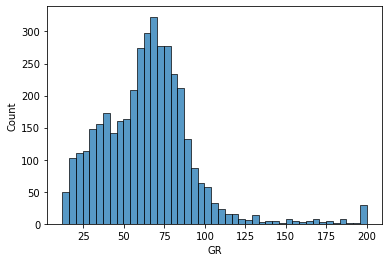

In [2]:
import seaborn as sns

sns.histplot(df['GR'])

We will split this dataset by group (well name):

In [4]:
features = ['GR', 'RHOB', 'PE']

test_wells = ['CRAWFORD', 'STUART']

test_flag = df['Well Name'].isin(test_wells)

X_test = df.loc[test_flag, features]
y_test = df.loc[test_flag, 'Lithology']

X_train = df.loc[~test_flag, features]
y_train = df.loc[~test_flag, 'Lithology']

## Using the `redflag` pipeline

There is a [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) you can use, containing all of the detectors. (At the time of writing, there are three components, but this is set to grow.)

In [5]:
import redflag as rf

rf.pipeline

Pipeline(steps=[('rf.imbalance', ImbalanceDetector()),
                ('rf.clip', ClipDetector()),
                ('rf.correlation', CorrelationDetector()),
                ('rf.outlier', OutlierDetector()),
                ('rf.distributions', DistributionComparator())])

We can use this in another pipeline:

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = make_pipeline(StandardScaler(), rf.pipeline, SVC())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('rf.imbalance', ImbalanceDetector()),
                                 ('rf.clip', ClipDetector()),
                                 ('rf.correlation', CorrelationDetector()),
                                 ('rf.outlier', OutlierDetector()),
                                 ('rf.distributions',
                                  DistributionComparator())])),
                ('svc', SVC())])

During the `fit` phase, the `redflag` transformers do three things:

- Check the target `y` for imbalance (if it is categorical).
- Check the input features `X` for issues like clipping and self-correlation.
- Learn the input feature distributions for later comparison.

In [7]:
pipe.fit(X_train, y_train)

🚩 The labels are imbalanced by more than the threshold (0.420 > 0.400).
🚩 Features 0, 1 may have clipped values.
🚩 Features 0, 1, 2 may have correlated values.
🚩 There are more outliers than expected in the training data (349 vs 31).


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('rf.imbalance', ImbalanceDetector()),
                                 ('rf.clip', ClipDetector()),
                                 ('rf.correlation', CorrelationDetector()),
                                 ('rf.outlier',
                                  OutlierDetector(threshold=3.3682141715600706)),
                                 ('rf.distributions',
                                  DistributionComparator())])),
                ('svc', SVC())])

When we pass in data for prediction, `redflag` checks the new inputs. There are two categories of check:

- Check for first-order issues, e.g. for clipping, or self-correlation.
- Compare statistics to the training data, e.g. to compare the distribution of the data or look for outliers.

In [8]:
y_pred = pipe.predict(X_test)
y_pred[:20]

🚩 Feature 0 may have clipped values.
🚩 Features 0, 1, 2 may have correlated values.
🚩 There are more outliers than expected in the data (30 vs 8).
🚩 Feature 2 has a distribution that is different from training.


array(['siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone'],
      dtype=object)

But you can't pass arguments to the `redflag_pipeline` components yet, for example to change the sensitivity of the `DistributionComparator`. To do that, use them separately.

## Using the 'detector' transformers

Let's construct a pipeline from `redflag`'s transformers directly.

Let's drop the clipped records of the GR log.

In [10]:
df = df.loc[df['GR'] < 200]

test_flag = df['Well Name'].isin(test_wells)

X_test = df.loc[test_flag, features]
y_test = df.loc[test_flag, 'Lithology']

X_train = df.loc[~test_flag, features]
y_train = df.loc[~test_flag, 'Lithology']

We know all this data is correlated to itself, so we can leave that check out.

We don't think the class imbalance is too troubling, so we raise the threshold on that.

We'll lower the confidence level of the outlier detector to 80% (i.e. we expect 20% of the data points will likely qualify as outliers). This might still trigger the detector in the training data.

Finally, we'll lower the threshold for the distribution comparison. This is the minimum Wasserstein distance required to trigger the warning.

So here's the new pipeline:

In [11]:
pipe = make_pipeline(StandardScaler(),
                     rf.ImbalanceDetector(threshold=0.5),
                     rf.ClipDetector(),
                     rf.OutlierDetector(p=0.80),
                     rf.DistributionComparator(threshold=0.25),
                     SVC())

Remember, feature 0 is no longer clipped, and the correlation detection is not being run. So we expect to see only the outlier issue, and the clipping issue with the RHOB column:

In [12]:
pipe.fit(X_train, y_train)

🚩 Feature 1 may have clipped values.
🚩 There are more outliers than expected in the training data (839 vs 626).


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('imbalancedetector', ImbalanceDetector(threshold=0.5)),
                ('clipdetector', ClipDetector()),
                ('outlierdetector',
                 OutlierDetector(p=0.8, threshold=2.154443705823081)),
                ('distributioncomparator',
                 DistributionComparator(threshold=0.25)),
                ('svc', SVC())])

The test dataset does not trigger the higher threshold for outliers. But with the new lower Wasserstein threshold, the distribution comparison fails for all of the features:

In [13]:
y_pred = pipe.predict(X_test)

🚩 Features 0, 1, 2 have distributions that are different from training.


## What to do about the warnings

If one of the detectors triggers, what should you do? Here are some ideas:


### `ImbalanceDetector`

- Check `rf.class_counts(y)` to see the support for each class in the dataset.
- Check `rf.minority_classes(y)` to see which classes are considered 'minority'.

This detector does not run during `transform`, only during `fit`. Usually, we don't worry about imbalance in data we are predicting on. If this is a concern for you, you can use `fit` on it (and make a GitHub Issue about it, because we could add an option to run during transform as well).


### `ClipDetector`

- Make sure the clipping values seem reasonable and do not lose a lot of dynamic range in the data (e.g. don't clip daily temperatures for Europe at 0 and 25 deg C).
- Check that the clipped data cannot be dealt with in some other way (e.g. you can attenuate very large values with a log transformation, if it makes sense in your data).
- Check that the clipped data should not simply be dropped from the dataset (e.g. if there are only a few values out of many, or if the other features also look suspicious for those records).

You may or may not be concerned about clipping. You may want to try training your models with and without the clipped records, to see if they make a difference to the model performance. I'm not aware of any research on this.


### `CorrelationDetector`

If the data is correlated to shifted versions of itself, e.g. because the data points are contiguous in time or space (daily temperature records, spatial measurements of rock properties, etc), then the so-called [IID assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) fails. In particular, your records are not independent. One of the big pitfalls with non-independent data is randomly splitting the data into train and test sets &mdash; you must not do this, it will result in information leakage and thus over-optimistic model evaulation. Instead, you should split the data using contiguous groups (date ranges, patient ID, borehole, or similar).


### `OutlierDetector`

There are a lot of ways of looking for outliers in data. The outlier detector only implements one strategy:

- Learn the robust location and covariance of the training data (you can think of these as outlier-insensitive, multi-dimensional analogs to mean and variance in a single random variable).
- As with the Gaussian distribution, we expect a certain number of samples to fall far from the centre of this distribution. For example, we expect 99.7% of values to be within 3 standard deviations of the mean.
- So, given a confidence level like 99.7%, `redflag` counts how many values are more than 3 SD's away. If there are more than expected (e.g.  we expect 3 samples out of 1000), the detector is triggered.
- The default confidence level is 99% (you expect 1% of the data to be noise), but you can change it.

So the location and covariance are learned from the training data; the detector then runs on the training data and on future datasets during the prediction phase (test, val, and in production).

If the detector is triggered, you should check which samples are considered outliers with `rf.get_outliers(method='mah', p=0.99)` (without your value for `p`). This function returns the _indices_ of the outlier samples. You can also use `rf.expected_outliers(*X.shape, p=0.99)` to check how many outliers you'd expect in the dataset, for a given value of `p`/.

You can check other methods, such as `iso` (isolation forest) to see if those also consider those samples to be outliers or not. If you think the samples are okay, you should keep them. If you think they are noise, you could remove them &mdash; but remember your model will not 'know' about these kinds of data points in the future and you should therefore remove them from future datasets too, before making predictions on them.


### `DistributionComparator`

Here's what this thing does:

- When you call `fit` (e.g. during training), the detector learns the empirical, binned distributions of your features, one at a time. No warnings can be emitted during fitting, you are only learning the distributions.
- When you call `transform` (e.g. during evaluation, testing, or in production), the detector compares the distributions in the data to those that were learned during fitting.
- The comparison uses the [1-Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric), or "earth mover's distance". Each feature is compared in turn; it is not a multivariate treatment. (If you'd like to see such a thing, please make a GitHub Issue, or have a crack at implementing it!)
- If the distance is more than the threshold, 1 by default, the warning is triggered.

If this detector triggers, it's a sign that you may have violated the 'identical  distribution' part of the [IID assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). You should examine the distributions of the features in the training data vs the current data that triggered the detector. For example, you can do this visually with something like Seaborn's `displot` or `kdeplot` functions.

A small difference, especially on just a few features, might just result from natural variance in the data and you may decide to ignore it. A large difference may be a result of forgetting to scale the data using the scaling parameters learned from the training data. A large difference could also result from trying to apply the model to a new 'domain', e.g. a new geographic location, set of patients, or type of widget. 

If you're in the model selection phase, it's possible that a different train/test split will give more comparable distributions.

### Feature importance comparator (coming soon)

- Negative importance suggests the feature is harming the prediction.
- Very low positive importance (compared to other features) suggests the feature does not contain much useful information.
- Very high importance in one or two features (compared to other features) suggests the feature(s) may be leaking information: check that it does not contain information about the target variable.